# 使用BERT进行中文文本分类

这是一个使用预训练语言模型BERT进行中文文本分类的简易教程，使用深度学习框架pytorch，数据为豆瓣读书评论数据:https://www.kaggle.com/datasets/tsaing/douban-book-review

## 安装`PyTorch`

如果使用CPU对预训练模型进行微调，则需要耗费大量时间，因此建议使用GPU进行训练。如果你的设备支持GPU，需要安装对应cuda版本的pytorch，首先在服务器命令行中输入`nvidia-smi`查看cuda版本，然后在下列网站中选择与服务器cuda版本对应的pytorch版本进行安装。

https://pytorch.org/get-started/previous-versions/

其他需要安装的包这里不再列出，可以在代码中查看。

## 安装`transformers`

transformers是一个用于处理自然语言的开源库，包含了BERT、GPT-2、RoBERTa、XLM、DistilBert、XLNet、T5、CTRL等预训练模型，以及对应的tokenizers，可以用于文本分类、文本生成、命名实体识别、问答等任务。

transformers的版本和pytorch版本需要匹配，可以在该网站了解安装步骤：

https://huggingface.co/docs/transformers/installation

使用pip或者conda安装均可。

In [146]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

# 设备准备

In [147]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 指定设备

if torch.cuda.is_available():
    # 使用编号为0的GPU，注意到指定之前先使用nvidia-smi查看是否有可用的GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [148]:
device

device(type='cuda')

# 导入数据

In [149]:
data_dir = '/kaggle/input/douban-book-review/'

In [150]:
# 这个文件有一些读取问题，这里采用下面链接中提到的解决方法：
# https://stackoverflow.com/questions/18016037/pandas-parsererror-eof-character-when-reading-multiple-csv-files-to-hdf5
import csv

In [151]:
train_df = pd.read_csv(f'{data_dir}/train.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)
dev_df = pd.read_csv(f'{data_dir}/dev.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(f'{data_dir}/test.tsv', sep='\t', encoding='utf-8', quoting=csv.QUOTE_NONE)

# 观察数据

In [152]:
print('train_df的前五行')
print('-------------------')
print(train_df.head())
print('-------------------')
print('dev_df的前五行')
print('-------------------')
print(dev_df.head())
print('-------------------')
print('test_df的前五行')
print('-------------------')
print(test_df.head())

train_df的前五行
-------------------
   label                                             text_a
0      0  都是些没用的鸡汤，基本没帮助。但是其中对于钟摆的理论令人深思，市场总是有自己的运作周期，最危...
1      0  挺好奇给这书打五星的读者群……心理学导论放了一段审问王明阳的电视剧片段，看了小说发现那段简直...
2      0                                           还能再啰嗦一点吗
3      0                                 没忍住一定打个较差……平时都不打分的
4      1       一本书很难将22个月，10公里的的旅程说清，其中的美妙与艰辛，需要我放下自己去经历体会。
-------------------
dev_df的前五行
-------------------
   label                                             text_a
0      1  怎么说呢，“这已经不是文学了，而是改造犯人的刑罚”，至少每个自己（并非每个人）都会有自己的地...
1      1                                      第一次体会文字上的极简主义
2      1                                               莱维的书
3      1                                            逻辑结构的历史
4      0                   挺没有意思的一本书，总觉得韩寒这人吧，老这样写小说真的挺没劲的。
-------------------
test_df的前五行
-------------------
   label                                             text_a
0      0  情欲，暗面，无爱。当然了，一些不堪的情欲确实存在于人身体里，有时候或者哪天会蹦出来撕扯。但我...
1      0  看到1/3的地方我安利了所有

**可以发现这里文本的一列叫做text_a，为方便后续索引将其改为`text`**

In [153]:
train_df.rename(columns={"text_a": "text"}, inplace=True)
dev_df.rename(columns={"text_a": "text"}, inplace=True)
test_df.rename(columns={"text_a": "text"}, inplace=True)

In [154]:
print('train_df的前五行')
print('-------------------')
print(train_df.head())
print('-------------------')
print('dev_df的前五行')
print('-------------------')
print(dev_df.head())
print('-------------------')
print('test_df的前五行')
print('-------------------')
print(test_df.head())

train_df的前五行
-------------------
   label                                               text
0      0  都是些没用的鸡汤，基本没帮助。但是其中对于钟摆的理论令人深思，市场总是有自己的运作周期，最危...
1      0  挺好奇给这书打五星的读者群……心理学导论放了一段审问王明阳的电视剧片段，看了小说发现那段简直...
2      0                                           还能再啰嗦一点吗
3      0                                 没忍住一定打个较差……平时都不打分的
4      1       一本书很难将22个月，10公里的的旅程说清，其中的美妙与艰辛，需要我放下自己去经历体会。
-------------------
dev_df的前五行
-------------------
   label                                               text
0      1  怎么说呢，“这已经不是文学了，而是改造犯人的刑罚”，至少每个自己（并非每个人）都会有自己的地...
1      1                                      第一次体会文字上的极简主义
2      1                                               莱维的书
3      1                                            逻辑结构的历史
4      0                   挺没有意思的一本书，总觉得韩寒这人吧，老这样写小说真的挺没劲的。
-------------------
test_df的前五行
-------------------
   label                                               text
0      0  情欲，暗面，无爱。当然了，一些不堪的情欲确实存在于人身体里，有时候或者哪天会蹦出来撕扯。但我...
1      0  看到1/3的地方我安利了所有

## 标签分布

`pandas.DataFrame.describe()`返回一个`pandas.DataFrame`，记录着数据类型为`numeric`和`object`的列的基本统计信息，这里将三个数据框的统计信息合并起来显示。注意默认情况下，`pandas.DataFrame.describe()`只会显示`numeric`类型的列的统计信息，正好这里我们只想看`label`这一列的信息，如果还想看`text`列的信息则需要将`include='all'`传入。

In [155]:
train_df.dtypes

label     int64
text     object
dtype: object

In [156]:
train_df['label'].describe()

count    20000.000000
mean         0.489050
std          0.499893
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [157]:
train_df.describe(include='all')

,label,text
count,20000.000000,20000
unique,NaN,19034
top,NaN,N
freq,NaN,216
mean,0.489050,NaN
std,0.499893,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,1.000000,NaN


In [158]:
pd.concat([
    train_df.describe().rename(columns={'label': 'train_label'}), 
    dev_df.describe().rename(columns={'label': 'dev_label'}), 
    test_df.describe().rename(columns={'label': 'test_label'})
], axis=1)

,train_label,dev_label,test_label
count,20000.000000,10000.000000,10000.000000
mean,0.489050,0.481200,0.489000
std,0.499893,0.499671,0.499904
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


可见，`P:N = 1:1`，`train:dev:test = 2:1:1`

# 定制豆瓣书评语料的Dataset类

In [159]:
from torch.utils.data import Dataset, DataLoader

In [160]:
class DoubanDataset(Dataset):
    def __init__(self, df, tokenizer, max_seq_len=256):
        # df: pandas dataframe
        # tokenizer: BertTokenizer
        # max_seq_len: int 指定最大序列长度
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]['text']
        label = self.df.iloc[idx]['label']
        # encode_plus会返回一个字典，字典中包含了input_ids, token_type_ids, attention_mask
        # input_ids：将文本转换为id序列
        # token_type_ids：将文本转换为id序列，同时区分两个句子
        # attention_mask：将文本转换为id序列，同时区分padding部分
        encoded_dict = self.tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_dict['input_ids']
        token_type_ids = encoded_dict['token_type_ids']
        attention_mask = encoded_dict['attention_mask']
        
        return input_ids, token_type_ids, attention_mask, label

# 初始化Tokenizer

## 预训练模型的存储位置

本实验使用中文预训练模型`bert-base-chinese`，该模型的存储位置为可以在该网站下载：

https://huggingface.co/bert-base-chinese

将其下载到本地后，将该位置huggingface相关函数接口，便可以使用该模型。或直接指出其名字`bert-base-chinese`，如果程序在当前目录下无法找到这个模型，则会自动从上述网站上下载，存储到当前用户下的某缓存文件夹中。建议在colab或kaggle等平台使用这种随时联网下载的方式，在服务器或本地使用时应该先下载并向函数指出其位置。

由于本程序在kaggle平台上进行测试，因此直接本代码中直接使用`bert-base-chinese`指明模型。

In [161]:
# 预训练模型的存储位置
pretrained_model_path = 'bert-base-chinese'


In [162]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [163]:
train_set = DoubanDataset(train_df, tokenizer, max_seq_len=128)
dev_set = DoubanDataset(dev_df, tokenizer, max_seq_len=128)
test_set = DoubanDataset(test_df, tokenizer=tokenizer, max_seq_len=128)

In [164]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
dev_loader = DataLoader(dev_set, shuffle=False, batch_size=32)
test_loader = DataLoader(test_set, shuffle=False, batch_size=32)

In [165]:
len(test_loader.dataset)

10000

## 网络定义

预训练模型的网络结构较为复杂，如果要自行定义，会非常麻烦，而且用户自己定义的网络结构可能和从huggingface上下载的模型有所区别，导致加载权重失败。

幸运的是，在huggingface上已经有人定义好了这些网络结构，我们只需要调用即可，这里我们使用`BertForSequenceClassification`，该网络结构的输入为`input_ids`和`attention_mask`，输出为`logits`，即每个类别的概率。

In [166]:
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### 温馨提示

加载模型后会出现一段提醒

```
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification:
...

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

这在加载一个新的预训练模型模型时是正常的，无需有任何担心。

可以打印网络结构出来查看，注意这个网络结构复杂，打印出的内容会非常多。

In [167]:
# print(model)

## 将网络加载到GPU

In [168]:
model = model.to(device)

# 损失函数与优化器

## 损失函数

huggingface的`BertForSequenceClassification`可以自动计算损失函数，因此我们只需要定义优化器即可。

## 优化器

这里使用AdamW，该优化器的参数与Adam相同，但是在优化过程中会对权重衰减，这样可以防止过拟合，并使得优化过程更加稳定。

同时注意到，由于预训练模型的大多数参数已经在预训练阶段训练好了，因此我们只需要对最后一层的参数进行优化，因此需要的学习率要小于从头训练网络时的学习率。

In [169]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


这里出现的`FutureWarning`的意思是，huggingface在transformers库中实现的`AdamW`即便被丢弃，之后建议使用`torch`中的`AdamW`优化器。这是因为一开始这个优化器PyTorch没有实现，但是用户们有需求，所以huggingface实现了一个供大家使用，PyTorch自己发布了这个优化器以后huggingface就建议大家使用PyTorch的实现，于是计划在未来的版本中丢弃自己实现的版本，以此减轻维护负担。但这里可以暂时不管，它不影响我们的任务。

In [170]:
def train_fn(model, data_loader, optimizer):
    model.train()
    losses = []
    for step, batch in enumerate(data_loader):

        # 将batch中的数据放到GPU上
        batch = [t.to(device) for t in batch]
 
        input_ids, token_type_ids, attention_mask, labels = batch
        
        # 去除张量中长度为1的维度
        input_ids = input_ids.squeeze(1)
        token_type_ids = token_type_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        
        outputs = model(input_ids=input_ids, 
                        token_type_ids=token_type_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % 100 == 0:
            print(f"step: [{step:>5d}/{len(data_loader):>5d}], loss: {loss.cpu().detach().numpy()}")

        losses.append(loss.cpu().detach().numpy())

    return losses

In [171]:
def test_fn(model, data_loader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            # 将batch中的数据放到GPU上
            batch = [t.to(device) for t in batch]

            input_ids, token_type_ids, attention_mask, labels = batch
            
            # 去除张量中长度为1的维度
            input_ids = input_ids.squeeze(1)
            token_type_ids = token_type_ids.squeeze(1)
            attention_mask = attention_mask.squeeze(1)

            outputs = model(input_ids=input_ids, 
                            token_type_ids=token_type_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            loss = outputs[0]
            logits = outputs[1]

            losses.append(loss.cpu().detach().numpy())

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return losses, correct / total

# 开始训练

预训练模型的微调过程相对较慢，请耐心等待

In [172]:
epochs = 2

for epoch in range(epochs):
    print(f'epoch: {epoch}')
    train_losses = train_fn(model, train_loader, optimizer)
    dev_losses, dev_acc = test_fn(model, dev_loader)
    print(f"dev loss: {np.mean(dev_losses)}, dev acc: {dev_acc}")

print('Done!')

epoch: 0
step: [    0/  625], loss: 0.7089338302612305
step: [  100/  625], loss: 0.6535621285438538
step: [  200/  625], loss: 0.41045430302619934
step: [  300/  625], loss: 0.2819065749645233
step: [  400/  625], loss: 0.420673131942749
step: [  500/  625], loss: 0.2371579110622406
step: [  600/  625], loss: 0.24067528545856476
dev loss: 0.2954002618789673, dev acc: 0.876
epoch: 1
step: [    0/  625], loss: 0.13649538159370422
step: [  100/  625], loss: 0.12772522866725922
step: [  200/  625], loss: 0.1753780096769333
step: [  300/  625], loss: 0.26616060733795166
step: [  400/  625], loss: 0.13550683856010437
step: [  500/  625], loss: 0.34087902307510376
step: [  600/  625], loss: 0.15794771909713745
dev loss: 0.3535459339618683, dev acc: 0.8641
Done!


# 绘制train / dev损失曲线

## train损失曲线

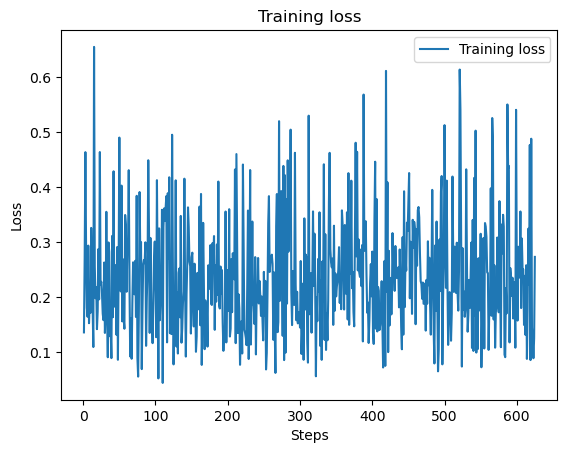

In [187]:
import matplotlib.pyplot as plt

steps = range(1, len(train_losses) + 1)
plt.plot(steps, train_losses, '-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 平滑化

上面的图看起来波动太大，因为是采样了每个mini-batch的损失值，可以采用平滑方法使这个图看起来更好，下面是chatgpt给出的一个平滑方法得到的图形，效果不错。

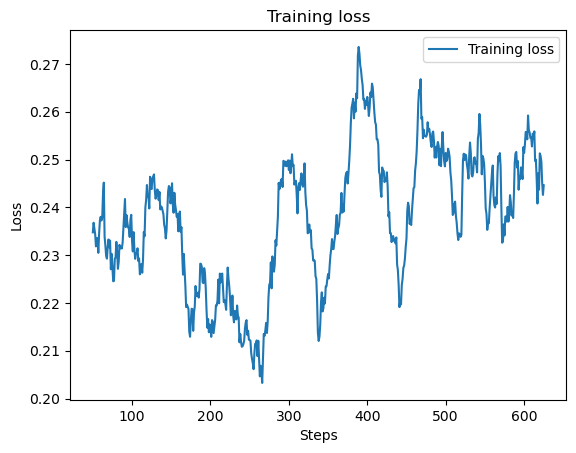

In [188]:
# Calculate rolling mean with window size of 50
window_size = 50
rolling_train_losses = pd.Series(train_losses).rolling(window_size).mean()

steps = range(1, len(train_losses) + 1)
plt.plot(steps, rolling_train_losses, '-', label='Training loss')
plt.title('Training loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

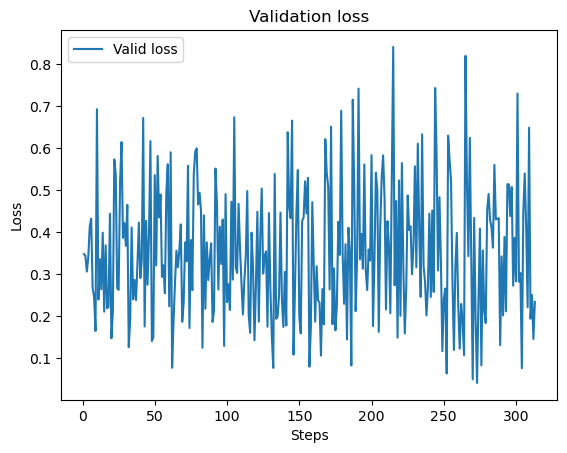

In [191]:
epochs = range(1, len(dev_losses) + 1)
plt.plot(epochs, dev_losses, '-', label='Valid loss')
plt.title('Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

对验证集上的损失也使用平滑方法进行绘图，可以看到在大约150个mini-batch（step）的时候损失最小，而总共有300step所有，因此只需要微调1个epoch就可以了，这和上面微调的时候输出的损失是一致的。

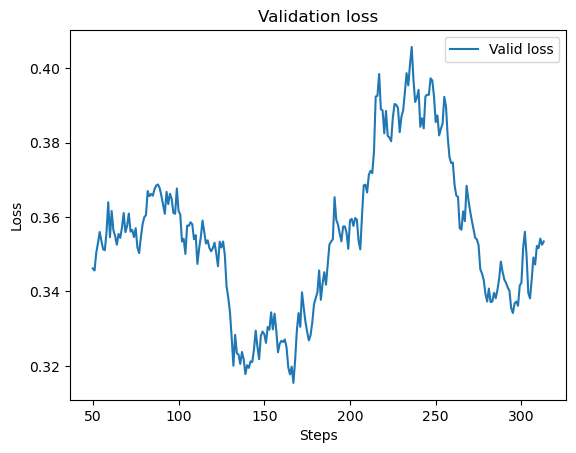

In [190]:
# Calculate rolling mean with window size of 50
window_size = 50
rolling_train_losses = pd.Series(dev_losses).rolling(window_size).mean()

steps = range(1, len(dev_losses) + 1)
plt.plot(epochs, rolling_train_losses, '-', label='Valid loss')
plt.title('Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 保存模型

In [175]:
torch.save(model.state_dict(), 'doubal-classification-bert.pth')

## 加载模型

注意到加载模型时要先实例化一个网络，然后再调用`load_state_dict()`方法加载参数。
在实际使用时需要，测试的代码有时候是和训练的代码分离的，这时候就需要把模型结构单独定义在一个文件里，然后在训练和测试的代码中都导入这个文件，这样就可以保证模型结构的一致性。

In [178]:
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)
model.load_state_dict(torch.load('doubal-classification-bert.pth'))
model = model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# 在测试集上测试

注意此时是用的最后一次训练后的模型，并不是在验证集上表现最好的模型。如果希望能取出验证集上表现最好的模型，可试运行几次，了解大概取得最好结果的epochs数，然后将epochs设为该值，去除验证集，在整个数据集上重新训练，并预测，也可以使用早停法(early stopping)，但吴恩达（Andrew Ng）不赞成使用早停法，因为该方法不是一个单变量控制。

In [180]:
# 测试模型
_, test_acc = test_fn(model, test_loader)

In [181]:
print(f"test acc: {dev_acc}")

test acc: 0.8641
